In [127]:
"""Detection visualization with GMM-colored patches."""
import random
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

from src.config.config import MainConfig
from src.data.preprocessed_dataset import PreprocessedDataset
from src.pca.incremental_pca import IncrementalPCAProcessor
from src.codebook.gmm_trainer import load_gmm_model
from src.visualization import (
    draw_bbox, draw_patches, patch_coords_in_crop, get_crop_bounds,
    compute_patch_responsibilities, responsibilities_to_colors
)

In [128]:
# Load config and models
config = MainConfig.from_yaml(Path("config_zebra_test.yaml"))
dataset = PreprocessedDataset(config.output_root)
pca = IncrementalPCAProcessor(config.pca, config.output_root)
gmm, gmm_metadata = load_gmm_model(config.gmm_model_path)

print(f"Loaded {dataset.get_total_detection_count()} detections")
print(f"GMM: {gmm.n_components} components")

DEBUG: Checking for PCA state at: /fs/ess/PAS2136/ggr_data/dino_data_2811/pca/pca_state.pkl
DEBUG: PCA state file exists: True
DEBUG: Loading PCA state from: /fs/ess/PAS2136/ggr_data/dino_data_2811/pca/pca_state.pkl
DEBUG: Restoring PCA object with 3068482 samples from save file
DEBUG: PCA was previously trained on 4411 images
DEBUG: After restoration, sklearn n_samples_seen_ = 3068482
Loaded 8271 detections
GMM: 64 components


In [129]:
# Pick random image with detections
image_paths = list(dataset._index['image_to_detections'].keys())
image_path = random.choice(image_paths)
detections = dataset.get_detections_for_image(image_path)
image = Image.open(image_path).convert('RGB')

print(f"Image: {Path(image_path).name}")
print(f"Detections: {len(detections)}")

Image: f7ca0a5a-91e6-8d9d-22d4-47a419c6c744.jpg
Detections: 1


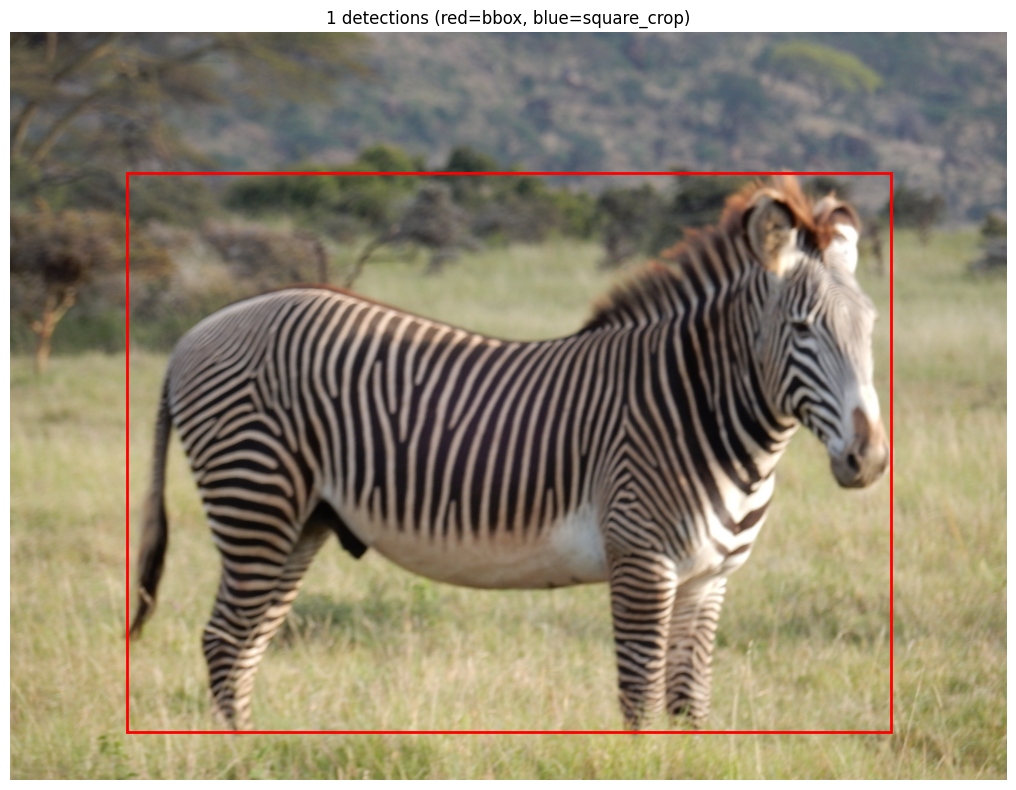

In [130]:
# Show image with bounding boxes
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
for det in detections:
    draw_bbox(ax, det.bbox, color='red', linewidth=2)
    # draw_bbox(ax, det.square_crop_bbox, color='blue', linewidth=1)
ax.set_title(f"{len(detections)} detections (red=bbox, blue=square_crop)")
ax.axis('off')
plt.tight_layout()
plt.show()

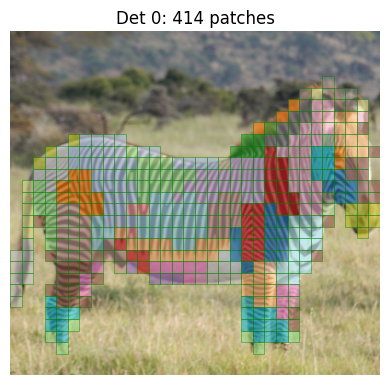

In [131]:
# Show each detection with GMM-colored patches
img_w, img_h = image.size
n_detections = len(detections)
cols = min(4, n_detections)
rows = (n_detections + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = [axes] if n_detections == 1 else axes.flatten()

for idx, det in enumerate(detections):
    ax = axes[idx]
    
    # Get crop
    x1, y1, x2, y2 = get_crop_bounds(det.square_crop_bbox, img_w, img_h)
    crop = image.crop((x1, y1, x2, y2))
    crop_w, crop_h = x2 - x1, y2 - y1
    
    ax.imshow(crop)
    
    # Compute GMM responsibilities and colors
    resp = compute_patch_responsibilities(det.features, det.patch_mask, pca, gmm)
    colors = responsibilities_to_colors(resp)
    
    # Draw colored patches
    coords = patch_coords_in_crop(det.patch_mask, crop_w, crop_h)
    draw_patches(ax, coords, colors=colors, alpha=0.6)
    
    ax.set_title(f"Det {idx}: {det.patch_mask.sum().item():.0f} patches")
    ax.axis('off')

# Hide unused axes
for idx in range(n_detections, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Load Fisher vectors
import numpy as np
from src.data.fv_dataset import FisherVectorDataset

fv_dataset = FisherVectorDataset(config.output_root / "fisher_vectors_reduced")
all_det_ids, all_fvs = fv_dataset.get_all_fisher_vectors()
all_fvs_norm = all_fvs / np.linalg.norm(all_fvs, axis=1, keepdims=True)

print(f"Loaded {len(all_det_ids)} Fisher vectors, dim: {all_fvs.shape[1]}")

Loaded 8271 Fisher vectors, dim: 512


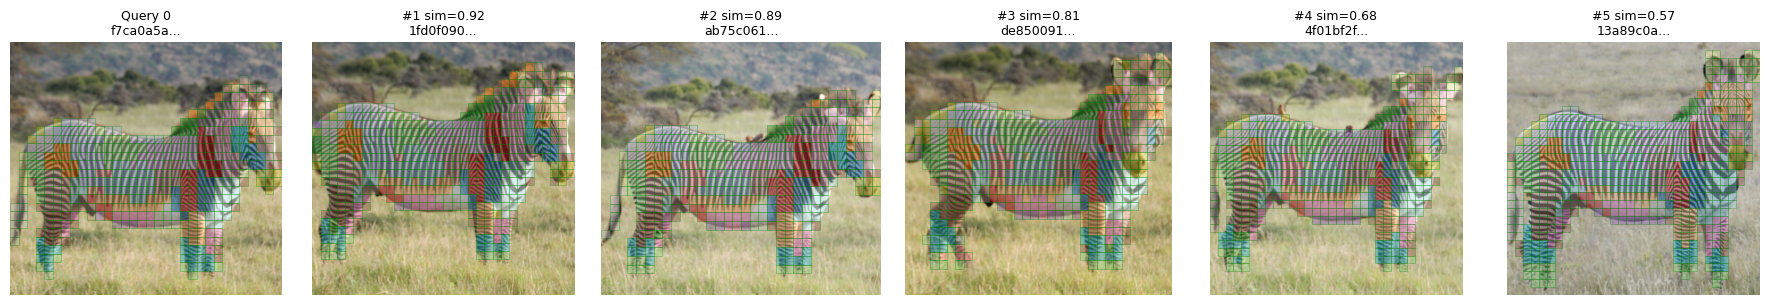

In [133]:
# Visualize top-5 matches for each detection
def show_detection_with_patches(ax, det, title, alpha=0.4):
    img = Image.open(det.image_path).convert('RGB')
    img_w, img_h = img.size
    x1, y1, x2, y2 = get_crop_bounds(det.square_crop_bbox, img_w, img_h)
    crop = img.crop((x1, y1, x2, y2))
    crop_w, crop_h = x2 - x1, y2 - y1
    
    ax.imshow(crop)
    
    # Draw GMM-colored patches
    resp = compute_patch_responsibilities(det.features, det.patch_mask, pca, gmm)
    colors = responsibilities_to_colors(resp)
    coords = patch_coords_in_crop(det.patch_mask, crop_w, crop_h)
    draw_patches(ax, coords, colors=colors, alpha=alpha)
    
    ax.set_title(title, fontsize=9)
    ax.axis('off')

for det_idx, query_det in enumerate(detections):
    # Find top-5 matches
    query_fv = fv_dataset.get_fisher_vector(query_det.detection_id)
    query_fv_norm = query_fv / np.linalg.norm(query_fv)
    similarities = all_fvs_norm @ query_fv_norm
    top_indices = np.argsort(similarities)[::-1][1:6]
    
    # Plot
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    show_detection_with_patches(axes[0], query_det, f"Query {det_idx}\n{query_det.detection_id[:8]}...")
    
    for i, idx in enumerate(top_indices):
        match_det = dataset.get_detection(all_det_ids[idx])
        show_detection_with_patches(axes[i+1], match_det, f"#{i+1} sim={similarities[idx]:.2f}\n{all_det_ids[idx][:8]}...")
    
    plt.tight_layout()
    plt.show()